In [1]:
import pandas as pd
import numpy as np
import re
import random
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
tweets_df = pd.read_csv("mide22_en_misinfo_tweets.tsv", sep="\t")
engagements_df = pd.read_csv("mide22_en_misinfo_user_engagements.tsv", sep="\t")
events_df = pd.read_csv("mide22_en_misinfo_events.csv")

# Uploaded folds (train + test)
train_files = ["en_train_0.tsv", "en_train_1.tsv","en_train_2.tsv", "en_train_3.tsv","en_train_4.tsv"]
test_files = ["en_test_0.tsv", "en_test_1.tsv","en_test_2.tsv", "en_test_3.tsv","en_test_4.tsv"]

train_df = pd.concat([pd.read_csv(f, sep="\t") for f in train_files], ignore_index=True)
test_df = pd.concat([pd.read_csv(f, sep="\t") for f in test_files], ignore_index=True)


In [3]:
test_df.head()

,Topic,Event,Label,Tweet_ID
0,Ukraine,EN05,Other,1509176120507187202
1,Ukraine,EN05,Other,1511256298238750721
2,Ukraine,EN05,False,1510055907740327951
3,Ukraine,EN05,False,1507117720772427782
4,Ukraine,EN05,Other,1511280127996477444


In [4]:
train_df.head()

,Topic,Event,Label,Tweet_ID
0,Ukraine,EN05,Other,1511085359840604171
1,Ukraine,EN05,Other,1511365138015694853
2,Ukraine,EN05,Other,1511481540655648769
3,Ukraine,EN05,Other,1511051409180999682
4,Ukraine,EN05,Other,1511288488301367298


In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')).union({'rt', 'via', 'amp', 'misinformation'})

def clean_text(text):
    text = re.sub(r"http\S+|@\S+|#\S+|[^a-zA-Z\s]", '', str(text).lower())
    tokens = [lemmatizer.lemmatize(t) for t in text.split() if t not in stop_words]
    return ' '.join(tokens)

def simulate_text(row):
    base_parts = []

    # Include topic + event
    base_parts.append(f"{row['Topic_x']} misinformation related to event {row['Event_x']}.")

    # Add actual tweet text if available
    if pd.notna(row.get('Text_x')) and isinstance(row['Text_x'], str):
        base_parts.append(f"Tweet content: {row['Text_x']}")

    # Include country (if metadata exists)
    if 'country' in row and pd.notna(row['country']):
        base_parts.append(f"This occurred in {row['country']}.")

    # Engagement summary
    engagement_summary = []
    if row.get('Like_Count', 0) > 0:
        engagement_summary.append(f"{row['Like_Count']} likes")
    if row.get('Retweet_Count', 0) > 0:
        engagement_summary.append(f"{row['Retweet_Count']} retweets")
    if row.get('Reply_Count', 0) > 0:
        engagement_summary.append(f"{row['Reply_Count']} replies")
    if row.get('Quote_Count', 0) > 0:
        engagement_summary.append(f"{row['Quote_Count']} quotes")

    if engagement_summary:
        base_parts.append("Engagements: " + ", ".join(engagement_summary) + ".")

    # Add a random misinformation-related narrative
    extras = [
        "Rumors are spreading fast.",
        "Unverified claims go viral.",
        "Authorities deny the reports.",
        "Trending now with fake details.",
        "Check your sources before sharing.",
        "Many users are misled by the narrative.",
        "It’s flagged as disinformation by fact-checkers.",
        "The claim lacks credible evidence.",
        "Virality does not imply truth.",
        "Critical thinking is necessary here."
    ]
    base_parts.append(random.choice(extras))

    return " ".join(base_parts)


def enrich_with_event_metadata(df):
    df = pd.merge(df, events_df, how='left', left_on='Event_x', right_on='Event')

    # Safely fill metadata columns that actually exist
    if 'Country' in df.columns:
        df['country'] = df['Country'].fillna('Unknown')
    else:
        df['country'] = 'Unknown'

    return df

In [6]:
def count_items(x):
    if pd.isna(x) or x == '':
        return 0
    return len(str(x).split(','))

def prepare_data(fold_df):
    df = pd.merge(fold_df, tweets_df, how="left", left_on="Tweet_ID", right_on="Tweet_id")
    df = pd.merge(df, engagements_df, how="left", left_on="Tweet_ID", right_on="tweet_id")
    df = enrich_with_event_metadata(df)

    df['Text'] = df.apply(simulate_text, axis=1)
    df['Label'] = df['Label_x'].apply(lambda x: 1 if x == 'False' else 0)
    df['Clean_Text'] = df['Text'].apply(clean_text)

    df['Text_Length'] = df['Clean_Text'].apply(lambda x: len(x.split()))
    df['Retweet_Count'] = df['retweet'].apply(count_items)
    df['Like_Count'] = df['like'].apply(count_items)
    df['Reply_Count'] = df['reply'].apply(count_items)
    df['Quote_Count'] = df['quote'].apply(count_items)

    return df[['Clean_Text', 'Label', 'Text_Length', 'Retweet_Count', 'Like_Count', 'Reply_Count', 'Quote_Count']]


train_data = prepare_data(train_df)
test_data = prepare_data(test_df)

In [7]:
train_data.head()

,Clean_Text,Label,Text_Length,Retweet_Count,Like_Count,Reply_Count,Quote_Count
0,ukraine related event en occurred unknown flag...,0,9,0,0,0,0
1,ukraine related event en occurred unknown chec...,0,9,2,7,2,0
2,ukraine related event en occurred unknown chec...,0,9,0,0,0,1
3,ukraine related event en occurred unknown rumo...,0,9,0,0,0,0
4,ukraine related event en occurred unknown clai...,0,10,0,0,0,0


In [8]:
test_data.head()

,Clean_Text,Label,Text_Length,Retweet_Count,Like_Count,Reply_Count,Quote_Count
0,ukraine related event en occurred unknown crit...,0,9,0,2,0,0
1,ukraine related event en occurred unknown vira...,0,9,0,0,0,0
2,ukraine related event en occurred unknown flag...,1,9,0,0,0,0
3,ukraine related event en occurred unknown chec...,1,9,0,2,0,0
4,ukraine related event en occurred unknown unve...,0,10,17,60,0,17


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter


/tmp/ipython-input-1000223331.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Label'].map({0: 'Other', 1: 'Misinformation'}), palette="Set2")


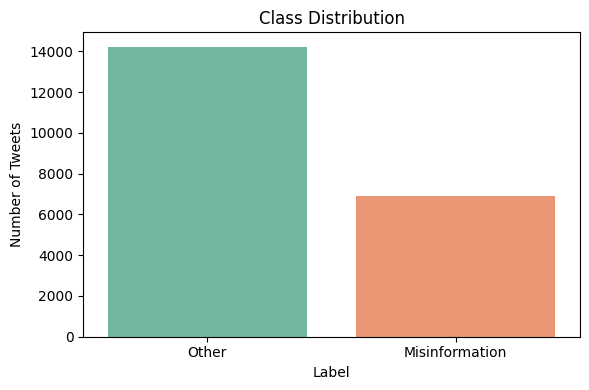

In [10]:
def plot_label_distribution(data):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=data['Label'].map({0: 'Other', 1: 'Misinformation'}), palette="Set2")
    plt.title("Class Distribution")
    plt.xlabel("Label")
    plt.ylabel("Number of Tweets")
    plt.tight_layout()
    plt.show()

plot_label_distribution(train_data)

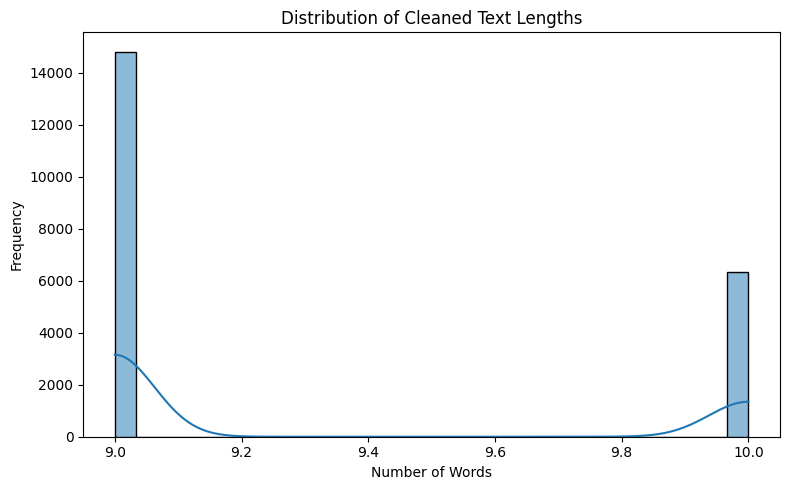

In [11]:
def plot_text_length(data):
    plt.figure(figsize=(8, 5))
    sns.histplot(data['Text_Length'], bins=30, kde=True)
    plt.title("Distribution of Cleaned Text Lengths")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_text_length(train_data)


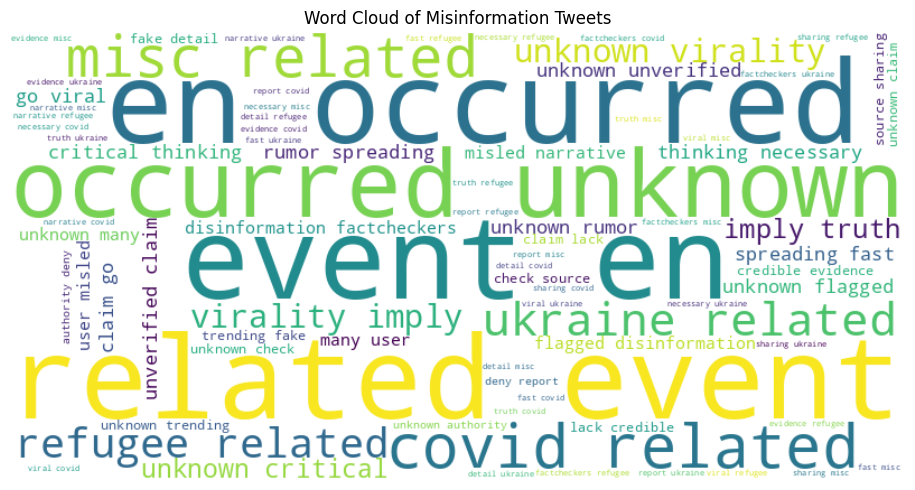

In [12]:
def wordcloud_misinfo(data):
    text = " ".join(data[data['Label'] == 1]['Clean_Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Misinformation Tweets")
    plt.tight_layout()
    plt.show()

wordcloud_misinfo(train_data)


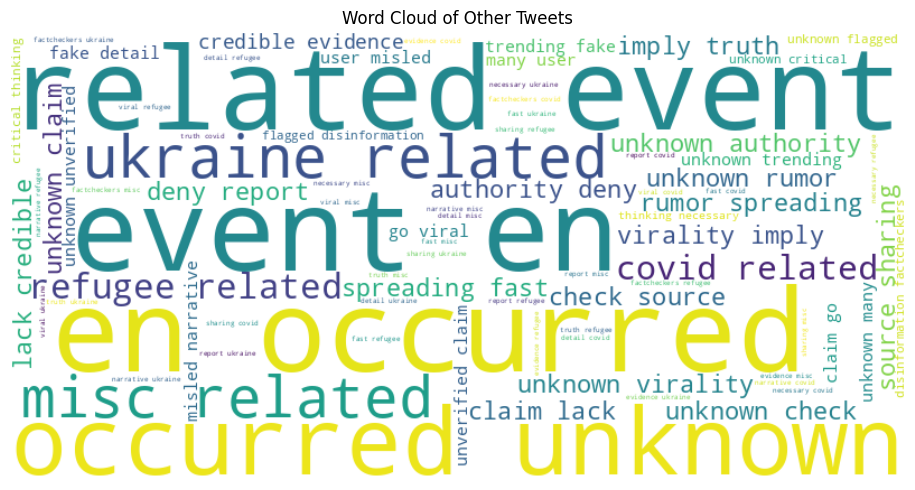

In [13]:
def wordcloud_other(data):
    text = " ".join(data[data['Label'] == 0]['Clean_Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Other Tweets")
    plt.tight_layout()
    plt.show()

wordcloud_other(train_data)

/tmp/ipython-input-1425909796.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['Other', 'Misinformation'])
/tmp/ipython-input-1425909796.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Other', 'Misinformation'])


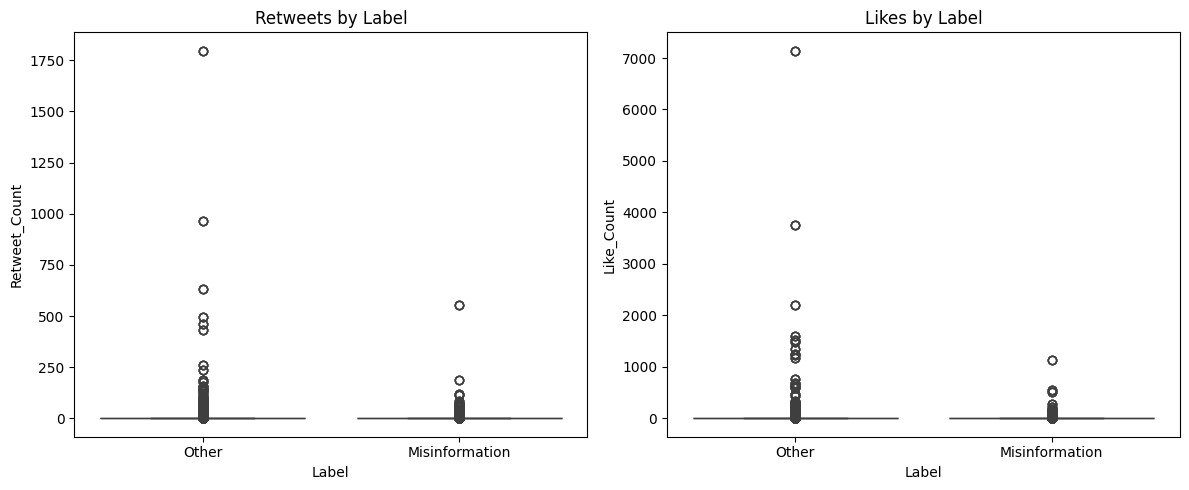

In [14]:
def plot_engagement_distribution(data):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.boxplot(x='Label', y='Retweet_Count', data=data, ax=axs[0])
    axs[0].set_title("Retweets by Label")
    axs[0].set_xticklabels(['Other', 'Misinformation'])

    sns.boxplot(x='Label', y='Like_Count', data=data, ax=axs[1])
    axs[1].set_title("Likes by Label")
    axs[1].set_xticklabels(['Other', 'Misinformation'])

    plt.tight_layout()
    plt.show()

plot_engagement_distribution(train_data)

/tmp/ipython-input-1497612727.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='cubehelix')


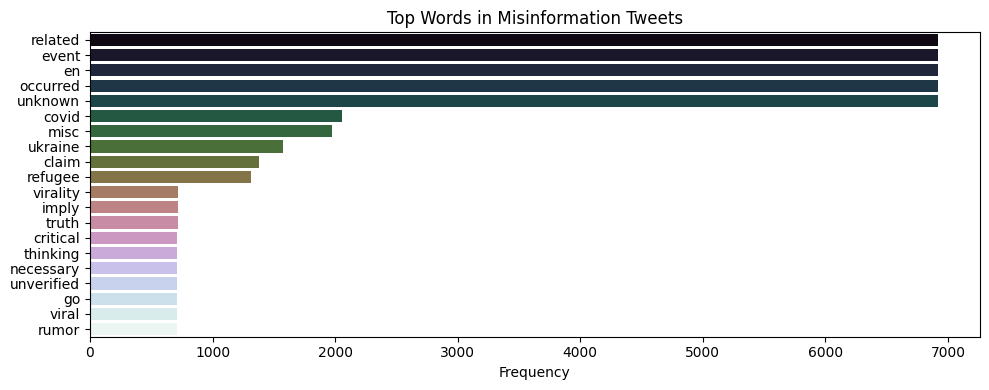

In [15]:
def top_words(data, label=1, n=20):
    texts = data[data['Label'] == label]['Clean_Text']
    words = " ".join(texts).split()
    top = Counter(words).most_common(n)
    words, counts = zip(*top)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(counts), y=list(words), palette='cubehelix')
    plt.title("Top Words in Misinformation Tweets" if label == 1 else "Top Words in Other Tweets")
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

top_words(train_data, label=1)


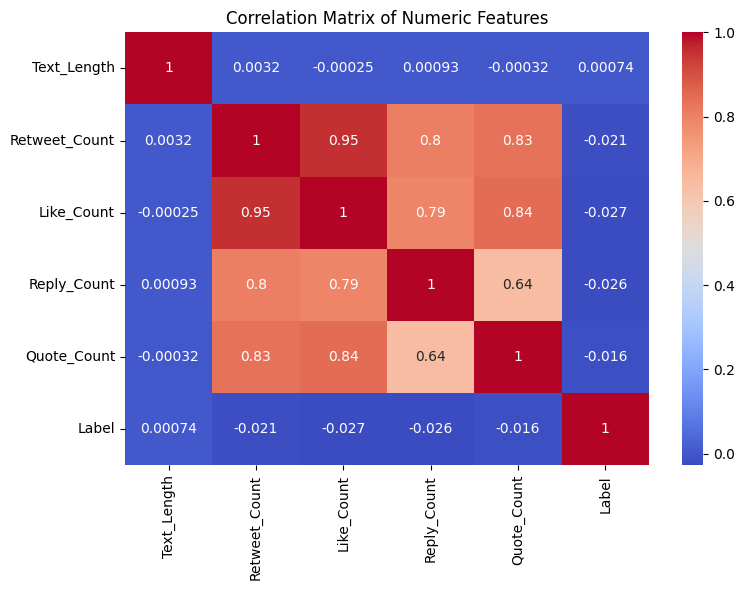

In [16]:
def plot_correlation_heatmap(data):
    plt.figure(figsize=(8, 6))
    corr = data[['Text_Length', 'Retweet_Count', 'Like_Count', 'Reply_Count', 'Quote_Count', 'Label']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix of Numeric Features")
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(train_data)


In [17]:
tfidf = TfidfVectorizer(max_features=1500, ngram_range=(1,2))
X_train_text = tfidf.fit_transform(train_data['Clean_Text'])
X_test_text = tfidf.transform(test_data['Clean_Text'])

# Combine with numerical features
X_train_full = np.hstack([
    X_train_text.toarray(),
    train_data[['Text_Length', 'Retweet_Count', 'Like_Count', 'Reply_Count', 'Quote_Count']].values
])

X_test_full = np.hstack([
    X_test_text.toarray(),
    test_data[['Text_Length', 'Retweet_Count', 'Like_Count', 'Reply_Count', 'Quote_Count']].values
])


y_train = train_data['Label']
y_test = test_data['Label']


In [18]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train)


In [19]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(max_iter=1000)

# Ensemble voting
ensemble = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('rf', rf),
    ('lr', lr)
], voting='soft')

models = {
    "XGBoost": xgb,
    "Random Forest": rf,
    "Logistic Regression": lr,
    "Ensemble": ensemble
}


In [20]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(max_iter=1000)

# Ensemble voting
ensemble = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('rf', rf),
    ('lr', lr)
], voting='soft')

models = {
    "XGBoost": xgb,
    "Random Forest": rf,
    "Logistic Regression": lr,
    "Ensemble": ensemble
}

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:34:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:34:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Improved Model Performance:

                     accuracy  precision    recall  f1_score
XGBoost              0.605034   0.430078  0.636784  0.513406
Random Forest        0.582513   0.402613  0.570272  0.471996
Logistic Regression  0.539932   0.369710  0.576056  0.450373
Ensemble             0.606170   0.423875  0.566802  0.485028


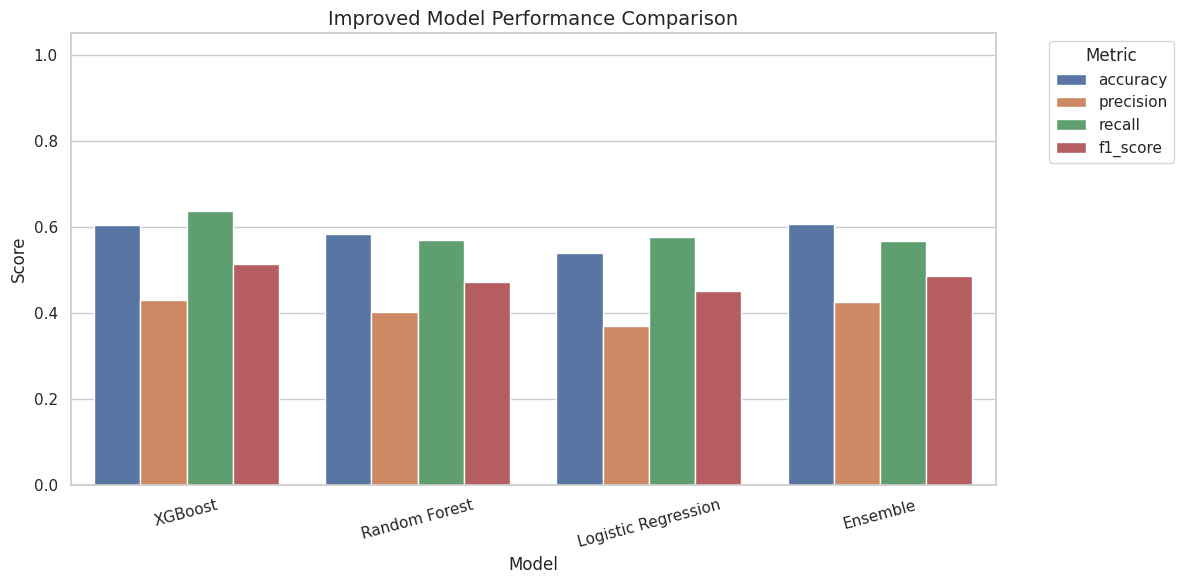

In [21]:
results = {}
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    preds = model.predict(X_test_full)
    results[name] = {
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds, zero_division=0),
        "recall": recall_score(y_test, preds, zero_division=0),
        "f1_score": f1_score(y_test, preds, zero_division=0)
    }

results_df = pd.DataFrame(results).T
print("\nImproved Model Performance:\n")
print(results_df)

# Plot
sns.set(style="whitegrid")
results_melted = results_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")
results_melted.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x="Model", y="Score", hue="Metric")
plt.title("Improved Model Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=15)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
